## AIN313-Assignment4

Ebrar Pınar Kuz - 2220765017

Zümral Yılmaz - 2230765026

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

from collections import Counter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import cdist_gak
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


Loaded: X=(599, 60, 50) | #videos=599 | classes=6
Train: (479, 60, 50) Test: (120, 60, 50)
Classes: [np.str_('boxing'), np.str_('handclapping'), np.str_('handwaving'), np.str_('jogging'), np.str_('running'), np.str_('walking')]
Base sigma ≈ 25.2499
Sigma candidates: [6.3125, 12.625, 25.2499, 50.4999, 100.9997]
[GAK+SVM] sigma=6.3125 | C=0.1 | acc=0.2917
[GAK+SVM] sigma=6.3125 | C=1.0 | acc=0.4333
[GAK+SVM] sigma=6.3125 | C=10.0 | acc=0.4333
[GAK+SVM] sigma=12.6250 | C=0.1 | acc=0.4750
[GAK+SVM] sigma=12.6250 | C=1.0 | acc=0.6500
[GAK+SVM] sigma=12.6250 | C=10.0 | acc=0.6583
[GAK+SVM] sigma=25.2499 | C=0.1 | acc=0.5250
[GAK+SVM] sigma=25.2499 | C=1.0 | acc=0.6250
[GAK+SVM] sigma=25.2499 | C=10.0 | acc=0.7417
[GAK+SVM] sigma=50.4999 | C=0.1 | acc=0.5000
[GAK+SVM] sigma=50.4999 | C=1.0 | acc=0.5917
[GAK+SVM] sigma=50.4999 | C=10.0 | acc=0.6667
[GAK+SVM] sigma=100.9997 | C=0.1 | acc=0.4667
[GAK+SVM] sigma=100.9997 | C=1.0 | acc=0.5750
[GAK+SVM] sigma=100.9997 | C=10.0 | acc=0.6250

=== BES

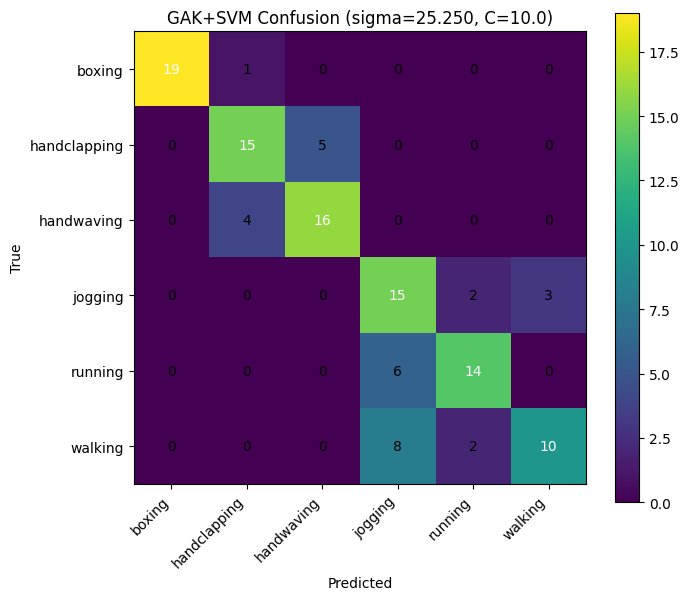

In [5]:

NPZ_DIR = "/kaggle/input/new-npz/npz_dataset" 
RANDOM_STATE = 42

MAX_LEN = 60          
USE_CONF = False      

# GAK + SVM 
C_LIST = [0.1, 1.0, 10.0]
SIGMA_MULTS = [0.25, 0.5, 1.0, 2.0, 4.0]


def infer_label_from_filename(path):
    
    base = os.path.basename(path).replace(".npz", "")
    parts = base.split("_")
    return parts[1] if len(parts) > 1 else "unknown"


def pick_pose_array(npz_obj):

    keys = npz_obj.files
    preferred = ["joints_normalized", "joints", "poses_norm", "poses"]
    for k in preferred:
        if k in keys:
            return npz_obj[k], k

    arrs = [(k, npz_obj[k]) for k in keys if isinstance(npz_obj[k], np.ndarray)]
    arrs.sort(key=lambda x: x[1].size, reverse=True)
    return arrs[0][1], arrs[0][0]


def resample_or_pad(seq_2d, max_len):
   
    T, D = seq_2d.shape
    if T == max_len:
        return seq_2d

    if T > max_len:
        idx = np.linspace(0, T - 1, max_len).astype(int)
        return seq_2d[idx]

    pad = np.zeros((max_len - T, D), dtype=seq_2d.dtype)
    return np.vstack([seq_2d, pad])


def estimate_sigma_flat(X, n_pairs=200, seed=42):
    
    rng = np.random.RandomState(seed)
    n = X.shape[0]
    if n < 2:
        return 1.0

    pairs = []
    for _ in range(n_pairs):
        i, j = rng.randint(0, n), rng.randint(0, n)
        if i != j:
            pairs.append((i, j))

    dists = []
    for i, j in pairs:
        d = np.linalg.norm(X[i].ravel() - X[j].ravel())
        dists.append(d)

    return float(np.median(dists)) if len(dists) else 1.0


def plot_confusion(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    # değerleri yaz
    thresh = cm.max() / 2 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()



def load_npz_dataset(npz_dir):
    X_list = []
    y_list = []

    files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
    if not files:
        raise FileNotFoundError(f"No npz found in: {npz_dir}")

    for f in files:
        data = np.load(f, allow_pickle=True)

        pose, pose_key = pick_pose_array(data)

        if "label" in data.files:
            label = str(data["label"])
        else:
            label = infer_label_from_filename(f)

        if pose.ndim == 3:

            if USE_CONF:
                feat = pose.reshape(pose.shape[0], -1)  
            else:
                feat = pose[:, :, :2].reshape(pose.shape[0], -1) 
        elif pose.ndim == 2:
            feat = pose
        elif pose.ndim == 4:
            pose = pose.squeeze(0)
            if USE_CONF:
                feat = pose.reshape(pose.shape[0], -1)
            else:
                feat = pose[:, :, :2].reshape(pose.shape[0], -1)
        else:
            raise ValueError(f"Unexpected pose shape {pose.shape} in {f} (key={pose_key})")

        feat = feat.astype(np.float32)
        feat = resample_or_pad(feat, MAX_LEN)

        X_list.append(feat)
        y_list.append(label)

    X = np.stack(X_list, axis=0)  
    y = np.array(y_list)
    print(f"Loaded: X={X.shape} | #videos={len(y)} | classes={len(set(y))}")
    return X, y


X_raw, y_raw = load_npz_dataset(NPZ_DIR)

X = TimeSeriesScalerMinMax().fit_transform(X_raw)

le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Classes:", list(le.classes_))


base_sigma = estimate_sigma_flat(X_train, n_pairs=200, seed=RANDOM_STATE)
sigma_candidates = [base_sigma * m for m in SIGMA_MULTS]

print(f"Base sigma ≈ {base_sigma:.4f}")
print("Sigma candidates:", [round(s, 4) for s in sigma_candidates])

best = {"acc": -1, "C": None, "sigma": None, "model": None}

for sigma in sigma_candidates:

    K_train = cdist_gak(X_train, sigma=sigma) 

    for C in C_LIST:
        clf = SVC(kernel="precomputed", C=C)

        clf.fit(K_train, y_train)

        K_test = cdist_gak(X_test, X_train, sigma=sigma)

        preds = clf.predict(K_test)
        acc = accuracy_score(y_test, preds)

        print(f"[GAK+SVM] sigma={sigma:.4f} | C={C} | acc={acc:.4f}")

        if acc > best["acc"]:
            best.update({"acc": acc, "C": C, "sigma": sigma, "model": clf})

print("\n=== BEST CONFIG ===")
print(best)

# EVALUATION
best_clf = best["model"]
K_test_best = cdist_gak(X_test, X_train, sigma=best["sigma"])
preds = best_clf.predict(K_test_best)

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, preds, target_names=le.classes_))

cm = confusion_matrix(y_test, preds)
plot_confusion(cm, le.classes_, title=f"GAK+SVM Confusion (sigma={best['sigma']:.3f}, C={best['C']})")

X: (599, 60, 50) lengths: (599,)
Label distribution: Counter({np.str_('boxing'): 100, np.str_('handwaving'): 100, np.str_('jogging'): 100, np.str_('running'): 100, np.str_('walking'): 100, np.str_('handclapping'): 99})
Classes: [np.str_('boxing'), np.str_('handclapping'), np.str_('handwaving'), np.str_('jogging'), np.str_('running'), np.str_('walking')]
Train: (383, 60, 50) Val: (96, 60, 50) Test: (120, 60, 50)
Epoch 001 | loss=1.2535 | val_acc=0.4792 | best=0.4792
Epoch 005 | loss=0.8188 | val_acc=0.6042 | best=0.6042
Epoch 010 | loss=0.5893 | val_acc=0.7188 | best=0.7188
Epoch 015 | loss=0.4623 | val_acc=0.8333 | best=0.8333
Epoch 020 | loss=0.3301 | val_acc=0.8438 | best=0.8438
Epoch 025 | loss=0.1675 | val_acc=0.8229 | best=0.9062
Epoch 030 | loss=0.1210 | val_acc=0.9167 | best=0.9167
Epoch 035 | loss=0.1362 | val_acc=0.8438 | best=0.9271
Epoch 040 | loss=0.0122 | val_acc=0.8958 | best=0.9271
Epoch 045 | loss=0.0031 | val_acc=0.9375 | best=0.9375

Best val acc: 0.9375

TEST ACC: 0.

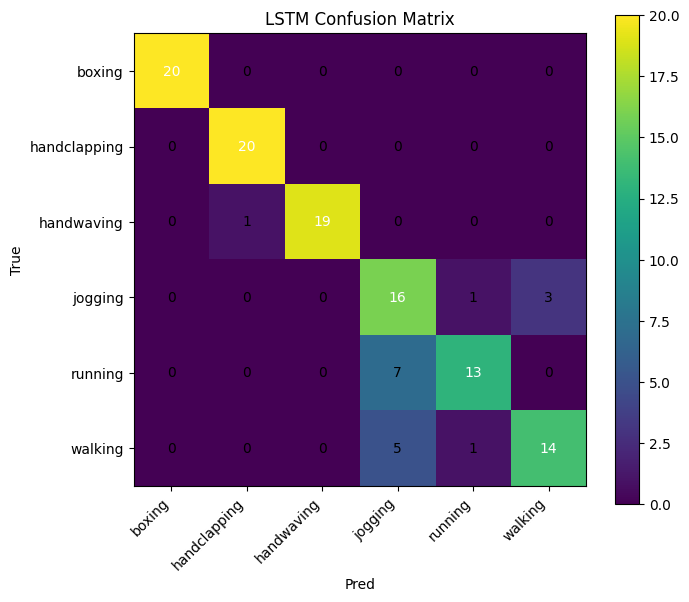

In [6]:
NPZ_DIR = "/kaggle/input/new-npz/npz_dataset"  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 42

MAX_LEN = 60        
USE_CONF = False    

BATCH_SIZE = 10
EPOCHS = 45
LR = 1e-3

LSTM_HIDDEN = 150
LSTM_LAYERS = 2
BIDIR = True
DROPOUT = 0.5


def infer_label_from_filename(path: str) -> str:
    base = os.path.basename(path).replace(".npz", "")
    parts = base.split("_")
    return parts[1] if len(parts) > 1 else "unknown"


def pick_pose_array(npz_obj):
    
    keys = npz_obj.files
    preferred = ["joints_normalized", "joints", "poses_norm", "poses"]
    for k in preferred:
        if k in keys:
            return npz_obj[k], k

    arrs = [(k, npz_obj[k]) for k in keys if isinstance(npz_obj[k], np.ndarray)]
    arrs.sort(key=lambda x: x[1].size, reverse=True)
    return arrs[0][1], arrs[0][0]


def resample_or_pad(seq_2d: np.ndarray, max_len: int):
    
    T, D = seq_2d.shape
    length = min(T, max_len)

    if T > max_len:
        idx = np.linspace(0, T - 1, max_len).astype(int)
        return seq_2d[idx], length

    if T < max_len:
        pad = np.zeros((max_len - T, D), dtype=seq_2d.dtype)
        return np.vstack([seq_2d, pad]), length

    return seq_2d, length


def plot_confusion(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    thresh = cm.max() / 2 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()


def load_npz_dataset(npz_dir: str):
    X_list, y_list, len_list = [], [], []

    files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
    if not files:
        raise FileNotFoundError(f"No npz found in: {npz_dir}")

    for f in files:
        data = np.load(f, allow_pickle=True)
        pose, pose_key = pick_pose_array(data)

        if "label" in data.files:
            label = str(data["label"])
        else:
            label = infer_label_from_filename(f)

        if pose.ndim == 3:
            
            if USE_CONF:
                feat = pose.reshape(pose.shape[0], -1)
            else:
                feat = pose[:, :, :2].reshape(pose.shape[0], -1)
        elif pose.ndim == 2:
            feat = pose
        elif pose.ndim == 4:
            pose = pose.squeeze(0) 
            if USE_CONF:
                feat = pose.reshape(pose.shape[0], -1)
            else:
                feat = pose[:, :, :2].reshape(pose.shape[0], -1)
        else:
            raise ValueError(f"Unexpected pose shape {pose.shape} in {f} (key={pose_key})")

        feat = feat.astype(np.float32)

        feat_fixed, length = resample_or_pad(feat, MAX_LEN)

        X_list.append(feat_fixed)
        y_list.append(label)
        len_list.append(length)

    X = np.stack(X_list, axis=0)                
    y = np.array(y_list)
    lengths = np.array(len_list, dtype=np.int64)
    return X, y, lengths


X_raw, y_raw, lengths_raw = load_npz_dataset(NPZ_DIR)

print("X:", X_raw.shape, "lengths:", lengths_raw.shape)
print("Label distribution:", Counter(y_raw))


le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))


X_train, X_test, y_train, y_test, L_train, L_test = train_test_split(
    X_raw, y, lengths_raw,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train, X_val, y_train, y_val, L_train, L_val = train_test_split(
    X_train, y_train, L_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


def compute_train_stats(X, L):

    all_frames = []
    for i in range(X.shape[0]):
        all_frames.append(X[i, :L[i], :])
    cat = np.concatenate(all_frames, axis=0)  # (sumL, D)
    mean = cat.mean(axis=0, keepdims=True).astype(np.float32)
    std = cat.std(axis=0, keepdims=True).astype(np.float32) + 1e-6
    return mean, std

mean, std = compute_train_stats(X_train, L_train)

def apply_norm(X, mean, std):
    return ((X - mean) / std).astype(np.float32)

X_train = apply_norm(X_train, mean, std)
X_val   = apply_norm(X_val, mean, std)
X_test  = apply_norm(X_test, mean, std)


class PoseSeqDataset(Dataset):
    def __init__(self, X, y, lengths):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.lengths = torch.from_numpy(lengths).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.lengths[idx], self.y[idx]


def collate_fn(batch):
    xs, ls, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    ls = torch.stack(ls, dim=0)
    ys = torch.stack(ys, dim=0)

    ls_sorted, idx = torch.sort(ls, descending=True)
    xs_sorted = xs[idx]
    ys_sorted = ys[idx]
    return xs_sorted, ls_sorted, ys_sorted


train_loader = DataLoader(PoseSeqDataset(X_train, y_train, L_train),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(PoseSeqDataset(X_val, y_val, L_val),
                          batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(PoseSeqDataset(X_test, y_test, L_test),
                          batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, bidir=True, dropout=0.3):
        super().__init__()
        self.bidir = bidir
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        out_dim = hidden_dim * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_dim, num_classes),
        )

    def forward(self, x, lengths):

        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        _, (h_n, _) = self.lstm(packed)

        if self.bidir:
            h_f = h_n[-2]  
            h_b = h_n[-1]
            h = torch.cat([h_f, h_b], dim=1)
        else:
            h = h_n[-1]

        return self.head(h)


input_dim = X_train.shape[-1]
model = LSTMClassifier(input_dim, LSTM_HIDDEN, LSTM_LAYERS, num_classes, bidir=BIDIR, dropout=DROPOUT).to(DEVICE)

class_counts = np.bincount(y_train, minlength=num_classes)
class_weights = (class_counts.sum() / (class_counts + 1e-6)).astype(np.float32)
class_weights = class_weights / class_weights.mean()
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))

optimizer = torch.optim.Adam(model.parameters(), lr=LR)


def run_eval(loader):
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, lb, yb in loader:
            xb, lb, yb = xb.to(DEVICE), lb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb, lb)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    return all_true, all_preds, accuracy_score(all_true, all_preds)


best_val = -1
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for xb, lb, yb in train_loader:
        xb, lb, yb = xb.to(DEVICE), lb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb, lb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    y_true_v, y_pred_v, val_acc = run_eval(val_loader)

    if val_acc > best_val:
        best_val = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | loss={total_loss/len(train_loader):.4f} | val_acc={val_acc:.4f} | best={best_val:.4f}")

model.load_state_dict(best_state)
print("\nBest val acc:", best_val)


y_true, y_pred, test_acc = run_eval(test_loader)
print("\nTEST ACC:", test_acc)

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plot_confusion(cm, le.classes_, title="LSTM Confusion Matrix")

/usr/local/lib/python3.12/dist-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--> Using Device: cuda
--> Loading data from /kaggle/input/new-npz/npz_dataset...
--> 599 videos loaded.

--> Step 1: Learning Shapelets...


/usr/local/lib/python3.12/dist-packages/tslearn/shapelets/shapelets.py:492: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_1' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-pac


--> Step 2: Training MLP...
Epoch [020/100], Loss: 0.9989
Epoch [040/100], Loss: 0.9749
Epoch [060/100], Loss: 0.9275
Epoch [080/100], Loss: 0.7718
Epoch [100/100], Loss: 0.7959

FINAL TEST ACCURACY: 0.5333

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      boxing       0.58      0.90      0.71        20
handclapping       0.55      0.90      0.68        20
  handwaving       0.77      0.50      0.61        20
     jogging       0.62      0.25      0.36        20
     running       0.00      0.00      0.00        20
     walking       0.37      0.65      0.47        20

    accuracy                           0.53       120
   macro avg       0.48      0.53      0.47       120
weighted avg       0.48      0.53      0.47       120



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


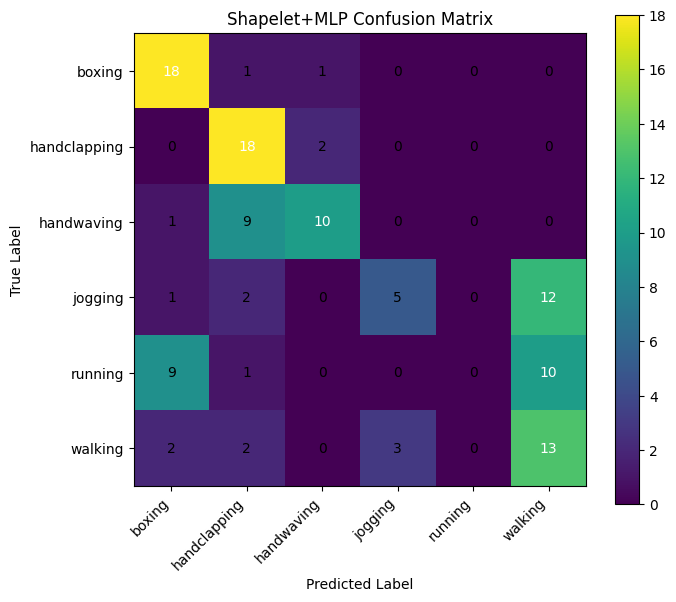

In [7]:

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

os.environ["KERAS_BACKEND"] = "torch"
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax

NPZ_DIR = "/kaggle/input/new-npz/npz_dataset"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> Using Device: {DEVICE}")

def plot_confusion(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    thresh = cm.max() / 2 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def load_data(npz_dir):
    print(f"--> Loading data from {npz_dir}...")
    x_data = []
    y_labels = []
    files = glob.glob(os.path.join(npz_dir, "*.npz"))
    for f in files:
        data = np.load(f)
        available_keys = data.files
        pose_key = 'pose_keypoints' if 'pose_keypoints' in available_keys else available_keys[0]
        label_key = 'label' if 'label' in available_keys else (available_keys[1] if len(available_keys) > 1 else None)
        pose = data[pose_key]
        label = data[label_key] if label_key else "unknown"
        if pose.ndim == 3:
            frames, joints, coords = pose.shape
            pose = pose.reshape(frames, joints * coords)
        elif pose.ndim == 4:
            pose = pose.reshape(pose.shape[1], -1)
        x_data.append(pose)
        y_labels.append(str(label))
    print(f"--> {len(x_data)} videos loaded.")
    return x_data, y_labels

x_raw, y_raw = load_data(NPZ_DIR)
MAX_LEN = 50 
x_processed = []
for sequence in x_raw:
    if len(sequence) > MAX_LEN:
        x_processed.append(sequence[:MAX_LEN])
    else:
        padding = np.zeros((MAX_LEN - len(sequence), sequence.shape[1]))
        x_processed.append(np.vstack((sequence, padding)))

X = np.array(x_processed)
le = LabelEncoder()
y = le.fit_transform(y_raw)
X = TimeSeriesScalerMinMax().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class ShapeletMLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=128):
        super(ShapeletMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

print("\n--> Step 1: Learning Shapelets...")
shapelet_model = LearningShapelets(
    n_shapelets_per_size={15: 10, 25: 10},
    max_iter=150,
    batch_size=32,
    verbose=0,
    random_state=42,
    scale=False
)

shapelet_model.fit(X_train, y_train)
X_train_dist = shapelet_model.transform(X_train)
X_test_dist = shapelet_model.transform(X_test)

print("\n--> Step 2: Training MLP...")
train_ds = TensorDataset(torch.FloatTensor(X_train_dist), torch.LongTensor(y_train))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

model = ShapeletMLP(X_train_dist.shape[1], len(le.classes_), hidden_size=128).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for b_x, b_y in train_loader:
        b_x, b_y = b_x.to(DEVICE), b_y.to(DEVICE)
        optimizer.zero_grad()
        out = model(b_x)
        loss = criterion(out, b_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch [{epoch:03d}/100], Loss: {total_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_dist).to(DEVICE)
    logits = model(X_test_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

final_test_acc = accuracy_score(y_test, preds)
print(f"\nFINAL TEST ACCURACY: {final_test_acc:.4f}")
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, preds, target_names=le.classes_))

cm = confusion_matrix(y_test, preds)
plot_confusion(cm, le.classes_, title="Shapelet+MLP Confusion Matrix")

--> X_train_scaled not found, regenerating with tslearn scaler...

=== Extra Method: XGBoost Training with Optimization ===
--> Starting Hyperparameter Optimization...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

FINAL TEST ACCURACY: 0.8417

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      boxing       1.00      0.80      0.89        20
handclapping       0.83      1.00      0.91        20
  handwaving       0.90      0.95      0.93        20
     jogging       0.76      0.65      0.70        20
     running       0.71      0.85      0.77        20
     walking       0.89      0.80      0.84        20

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120



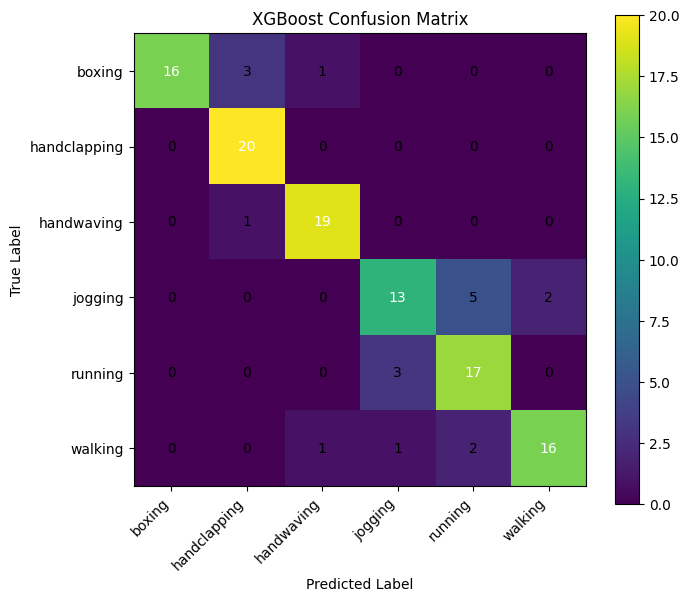

In [8]:

warnings.filterwarnings("ignore")

def plot_confusion(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    thresh = cm.max() / 2 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

if 'X_train_scaled' not in locals():
    print("--> X_train_scaled not found, regenerating with tslearn scaler...")
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
    ts_scaler = TimeSeriesScalerMeanVariance()
    X_train_scaled = ts_scaler.fit_transform(X_train)
    X_test_scaled = ts_scaler.transform(X_test)

def extract_statistical_features(X):
    n_samples, n_steps, n_features = X.shape
    features_list = []
    for i in range(n_samples):
        sample = X[i] 
        mean = np.mean(sample, axis=0)     
        std = np.std(sample, axis=0)       
        max_val = np.max(sample, axis=0)   
        diff = np.diff(sample, axis=0)      
        velocity = np.mean(np.abs(diff), axis=0) 
        combined = np.hstack([mean, std, max_val, velocity])
        features_list.append(combined)
    return np.array(features_list)

print("\n=== Extra Method: XGBoost Training with Optimization ===")

X_train_xgb = extract_statistical_features(X_train_scaled)
X_test_xgb = extract_statistical_features(X_test_scaled)

scaler_xgb = StandardScaler()
X_train_xgb = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb = scaler_xgb.transform(X_test_xgb)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 200]
}

base_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    tree_method='hist', 
    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_state=42
)

grid_search = GridSearchCV(base_xgb, param_grid, cv=3, scoring='accuracy', verbose=1)
print("--> Starting Hyperparameter Optimization...")
grid_search.fit(X_train_xgb, y_train)

best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

y_pred_xgb = best_xgb.predict(X_test_xgb)

test_acc = accuracy_score(y_test, y_pred_xgb)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion(cm, le.classes_, title=f"XGBoost Confusion Matrix")



# Project Report

## INTRODUCTION
In this project, we work on human action recognition from video data. This is a common computer vision and machine learning problem. The goal is to identify the type of activity by using motion information in the video.

First, we transform the video data into pose-based time-series data using **OpenPose**. We do this because raw pixel data is too expensive to compute. OpenPose detects body joints to focus on motion patterns. This approach reduces data dimensionality and makes it more suitable for time-series analysis.

To classify these motions, we tested four different approaches:
* **Global Alignment Kernel (GAK) + SVM:** Measures similarity between time-series sequences to separate the six activity classes.
* **Shapelet Transform + MLP:** Learns short, informative subsequences (shapelets) and uses their distances as features for a Multilayer Perceptron (MLP).
* **LSTM:** A Long Short-Term Memory network used to directly learn temporal dependencies and patterns from pose sequences.
* **XGBoost:** An extra method using extracted statistical features (like mean and velocity) to compare classical machine learning with deep learning.

---

## OPENPOSE
Our aim in this part is converting video data to `.npz` format, which allows models to process data more easily. We used the **OpenPose library with Body-25 (25 joints)**.

### Installation and Challenges
Initially, we tried to compile the library in an Ubuntu environment using GPU and CUDA for faster results. While the installation seemed successful, the generated JSON files were empty. We suspected Python version incompatibility, but since re-installing CUDA, cuDNN, and Python versions is a complex and uncertain process, we sought alternative methods.

### Final Pipeline
We decided on the most optimal way: installing OpenPose as an `.exe` and adding the Body-25 components.
1.  **JSON Creation:** We created JSON files containing coordinate data for each frame.
2.  **Conversion:** These files were converted into time-series sequences.
3.  **Compression:** Finally, we obtained compressed data in `.npz` format ready for model training.

---

## MODELS

### 1. Global Alignment Kernel (GAK) + SVM
In this approach, OpenPose data is treated as a time series. GAK uses a kernel function that measures the similarity between two time series, even if there are shifts in time. Classical SVM is often insufficient for time-series data, but GAK allows for a more holistic similarity measurement.

* **Parameters:** We tested sigma multipliers `[0.25, 0.5, 1.0, 2.0, 4.0]` and SVM `C` parameters `[0.1, 1.0, 10.0]`.
* **Results:** The best performance was achieved with **C = 10** and **sigma = 25.25**, resulting in **0.74 accuracy**.
* **Analysis:** The model was most successful at predicting "boxing" but struggled with "walking." Most errors occurred between physically similar classes like jogging, running, and walking.

### 2. LSTM (Long Short-Term Memory)
LSTM is an RNN structure designed to learn short and long-term dependencies in sequential data. It processes pose vectors frame-by-frame to make class predictions.

* **Optimization:** Our initial results showed overfitting (0.75 test vs 0.93 validation). To solve this, we:
    * Increased **dropout**.
    * Decreased the **epoch number**.
    * Reduced **batch size**.
    * Increased the **LSTM hidden size**.
* **Results:** The final model reached **≈0.95 validation accuracy** and **≈0.83 test accuracy**. It was highly successful for "handwaving," "handclapping," and "boxing."

### 3. Shapelet Transform + MLP
This method uses "shapelets"—small, representative subsequences that are highly discriminative for specific classes.

* **Process:** 1.  The algorithm finds informative subsequences.
    2.  Videos are transformed into a vector of "distances" to these shapelets.
    3.  A Multilayer Perceptron (MLP) classifies these distance features.
* **Results:** Using 20 shapelets and an MLP (128 and 64 neurons), we achieved **0.53 accuracy**.
* **Analysis:** While successful for "boxing" and "handclapping" (0.90 recall), the model **completely failed to detect running**. It often confused running with boxing or walking.

### 4. XGBoost (Extra Method)
We chose XGBoost because Gradient Boosting structures are powerful for capturing patterns in structured data.

* **Feature Extraction:** Instead of raw sequences, we calculated four statistical values for each video:
    * **Mean:** Average position of joints.
    * **Standard Deviation:** Range of movement.
    * **Maximum Value:** Furthest points reached.
    * **Velocity:** Speed of movement between frames.
* **Results:** After hyperparameter optimization (Grid Search), XGBoost became our best model with **0.8417 accuracy**. 
* **Analysis:** It performed exceptionally well on "handwaving" and "handclapping." Features like "velocity" made it easy to distinguish between fast and slow actions, though some confusion remained between jogging and running.

---

## CONCLUSION
This project demonstrated the effectiveness of different machine learning models for human action recognition using pose data. By converting video into time-series sequences of joint coordinates, we focused on motion patterns rather than raw pixels.

**Performance Summary:**
1.  **XGBoost (0.8417):** The highest accuracy, confirming that statistical summaries (like velocity) are extremely powerful for speed-based actions.
2.  **LSTM (0.83):** Strong performance in learning temporal dependencies from sequential data.
3.  **GAK + SVM (0.74):** Effective for similarity measurement but struggled with physically similar classes.
4.  **Shapelet Transform + MLP (0.53):** Lowest accuracy; while good for specific patterns, it failed to generalize for complex actions like running.

**Final Note:** While deep learning (LSTM) is the standard for time-series, traditional boosting methods (XGBoost) can outperform them when combined with expert-defined statistical features. Future work could explore a hybrid model combining both temporal learning and statistical summaries.